In [1]:
!pip install pyspark


     |████████████████████████████████| 212.4MB 65kB/s 
     |████████████████████████████████| 204kB 16.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=57adc005f5590f5b9d58519793d9239de1b7c8db65c075211e6f372b2b83a267
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from pyspark import SparkConf, SparkContext

import pickle
from functools import reduce

In [7]:
sc = SparkContext(conf=SparkConf())
def l22(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + b * b, delta, 0)

def l1(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + abs(b), delta, 0)

def findCentroid(pt, cens, distFcn, phi):
    best = float('inf')
    besti = None
    for i, cen in enumerate(cens.value):
        cand = distFcn(pt, cen)
        if cand < best:
            best = cand
            besti = i
    phi += best
    return besti, pt

def aggregate_UV(cumulative, pt):
    cumulative_pt, cumulative_cnt = cumulative
    for i in range(len(pt)):
        cumulative_pt[i] += pt[i]
    return cumulative_pt, cumulative_cnt + 1

def aggregate_UU(a, b):
    a_pt, a_cnt = a
    b_pt, b_cnt = b
    for i in range(len(a_pt)):
        a_pt[i] += b_pt[i]
    return a_pt, a_cnt + b_cnt

dataDir = '/content/drive/MyDrive/HW2bd/data/'
dataFile = 'data.txt'
#censFile = 'c1.txt'
censFile = 'c2.txt'
#distFcn = l1
distFcn = l22
outFile = 'dist_' + distFcn.__name__ + '__' + censFile

MAX_ITER = 20
k = 10
# NDATA = 4601
NDIM = 58

# init centroids
cens = []
with open(dataDir + censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

# load data
data = sc.textFile(dataDir + dataFile)
data = data.map(lambda l: list(map(float, l.split())))

phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 2 + 'iteration %d' % it + '\n' * 2)

    #assign each pt to a centroid
    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    # update centroids
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    # record cost, prep new iter
    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print(totCosts)
sc.stop()

with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)



iteration 1




iteration 2




iteration 3




iteration 4




iteration 5




iteration 6




iteration 7




iteration 8




iteration 9




iteration 10




iteration 11




iteration 12




iteration 13




iteration 14




iteration 15




iteration 16




iteration 17




iteration 18




iteration 19




iteration 20


[438747790.02791756, 249803933.62600276, 194494814.40631253, 169804841.4515432, 156295748.8062759, 149094208.10896596, 142508531.61961532, 132303869.40652987, 117170969.83719075, 108547377.17857003, 102237203.3179959, 98278015.74975666, 95630226.12177408, 93793314.051193, 92377131.96821065, 91541606.25423889, 91045573.83042458, 90752240.10140811, 90470170.18122731, 90216416.1756313]


L2^2 c1 0.2648391714456053
L2^2 c2 0.7669795594605946
L1   c1 0.18654709691385904
L1   c2 0.515540991023891


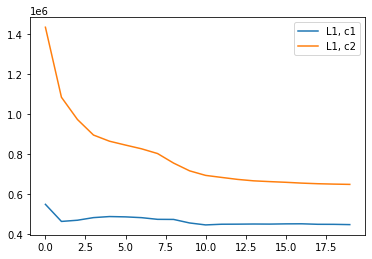

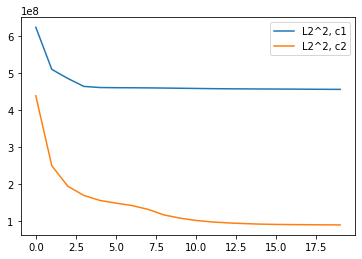

In [6]:
import matplotlib.pyplot as pl
import pickle
pl.close('all')

with open('dist_l1__c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('dist_l1__c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('dist_l22__c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('dist_l22__c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)


pl.plot(l1c1, label='L1, c1')
pl.plot(l1c2, label='L1, c2')
pl.legend()

pl.figure()
pl.plot(l22c1, label='L2^2, c1')
pl.plot(l22c2, label='L2^2, c2')
pl.legend()

def change(L):
    return (L[0] - L[10]) / L[0]

print('L2^2 c1', change(l22c1))
print('L2^2 c2', change(l22c2))
print('L1   c1', change(l1c1))
print('L1   c2', change(l1c2))
